In [25]:
import re
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import numpy as np
from IPython.display import display, Markdown, Latex
from sympy import Matrix, MatrixSymbol
from sympy import Symbol, Eq
from sympy import init_printing, sympify
import sympy
init_printing()
import scipy
from scipy.sparse import block_diag
import scipy.optimize
import cv2
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection


In [26]:
samples = []

with open("movements_points.txt", 'rt') as f:
    for line in f:
        match = re.match('^sweep: s0\(([^)]+)\) s1\(([^)]+)\) s1start\((\d+)\) sensor0\((\d+)\)$', line.strip())
        s0 = match.group(1)
        s1 = match.group(2)
        s1_start_time = int(match.group(3))
        time = int(match.group(4))
        
        if "s0" in s0:
            station = 0
        else:
            station = 1
            time = time - s1_start_time
        
        if "a0" in s0:
            axis = 0
        else:
            axis = 1
            
        samples.append(((station, axis), time))

In [382]:
# Find ticks per rotation

# Clock frequency of timer is 16MHz
clock_freq = 16000000
clock_period = 1 / clock_freq

# Rotors rotate at 60Hz
rotor_period = 1 / 60

ticks_per_rotation_f = rotor_period / clock_period
ticks_to_center_f = ticks_per_rotation / 4
ticks_to_rad = (2*np.pi)/ticks_per_rotation_f

In [383]:
points = []

pos = 0
while len(samples) > pos+4:
    vals = [samples[pos], samples[pos+1], samples[pos+2], samples[pos+3]]
    pos += 4
    
    raw_vals = list(map(lambda s: s[1], vals))
    
    assert(vals[0][0][0] == 0)
    assert(vals[0][0][1] == 0)

    for val in raw_vals:
        if val < 0:
            continue
    
    # Use 66000 as the center. It doesn't really matter all that much since the geometry of the rotor
    # *should* be relatively uniform throughout the rotation.
    # Since we currently use 16MHz as the timer clock, make things easy for us later if we want to
    # change it, use 16000 as a divisor.
    points.append((
            (vals[0][1]-ticks_to_center_f)*ticks_to_rad,
            (vals[1][1]-ticks_to_center_f)*ticks_to_rad,
            (vals[2][1]-ticks_to_center_f)*ticks_to_rad,
            (vals[3][1]-ticks_to_center_f)*ticks_to_rad
        ))

In [384]:
# Convert to homogenous coordinates (projective space)
points_transposed = np.transpose(points)

bsa_points = np.transpose([points_transposed[0], points_transposed[1]])
bsb_points = np.transpose([points_transposed[2], points_transposed[3]])

def rot_to_homog(point):
    return np.array([
            np.sin(point[1]),
            -np.sin(point[0]) * np.cos(point[1]),
            np.cos(point[0]) * np.cos(point[1])
        ])

bsa_homog_rays = np.array(list(map(rot_to_homog, bsa_points)))
bsb_homog_rays = np.array(list(map(rot_to_homog, bsb_points)))

bsa_homog_rays

array([[ 0.04405443,  0.02550573,  0.99870349],
       [ 0.0485264 ,  0.02472406,  0.99851585],
       [ 0.05240916,  0.02401353,  0.99833693],
       ...,
       [-0.2061316 ,  0.09350264,  0.97404672],
       [-0.2075839 ,  0.09381745,  0.97370797],
       [-0.20875923,  0.09383933,  0.97345455]])

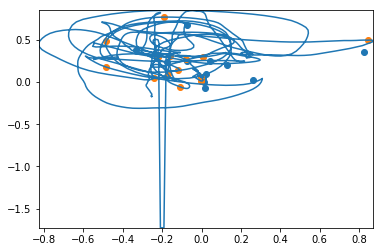

In [385]:
sampled_points = [points[100], points[200], points[300], points[400], points[500], points[600], points[700], points[800], points[900], points[1000], points[1100], points[1200], points[1300], points[1400]]

fig = plt.figure()

inverted = np.transpose(points)

ax = fig.add_subplot(111)

sampled_points_inverted = np.transpose(sampled_points)
ax.scatter(sampled_points_inverted[0], sampled_points_inverted[1])
ax.scatter(sampled_points_inverted[2], sampled_points_inverted[3])

line = Line2D(inverted[2], inverted[3])
ax.add_line(line)

lh0_a0_ptp = (min([min(inverted[0]), min(inverted[2])]), max([max(inverted[0]), max(inverted[2])]))
lh0_a1_ptp = (min([min(inverted[1]), min(inverted[3])]), max([max(inverted[1]), max(inverted[3])]))
ax.set_xlim(lh0_a0_ptp[0], lh0_a0_ptp[1])
ax.set_ylim(lh0_a1_ptp[0], lh0_a1_ptp[1])

plt.show()

## Glossary
* tbss problem: two-basestation-sensor problem
* bs: basestation (also referred to as cameras, analogous to a camera in photogrammetry)
* baseline: line between the two basestations
* fov: field of view
* world: Our mathematical model of the world. Presumably contains the positions of the BSes and sensors.
* baseline: the vector between the optical centers of our two lighthouses

**Note: This is very very similar to photogrammetry in several areas, and a lot of the ideas, solutions and terminology is taken from that field.**

## TBSS problem
The TBSS problem consists of two BSes at random positions and rotations. Due to real life physics, BS positions cannot be coincident.

The TBSS problem is a problem of 5 unknowns:
* 3 variables in relative orientation between the BSes.
* 2 variables in the baseline

There are several things we can't figure out without any further infomation:
* The down direction in the world. This can be constrained by getting a single reference down direction.
* The scale of the world. This can be constrained by getting the distance between two measured points in the world. (BS to sensor, sensor to sensor, BS to BS)

### Base station down vector
**As is, it seems like the down vector only has one working axis. The other two are broken. While the one dimention can still be used, it doesn't provide many advantages, and I probably won't bother.**

As it turns out, the ootx block gives us a down vector for both BSes. This can be utilized to reduce the unknowns by 2, and constrain the absolute orientation to our world.

When we constrain the rotation of a single BS at an axis, we reduce the 3 unknowns in the orientation of the BS to 1 (the rotation around that axis). Since the down vector of the first BS and second BS should be parallel, this will constrain the relative orientation of the two BSes to 1 axis.

This will reduce our total number of variables to solve for to 3.

### Improvements
Because the TBSS problem only considers one sample point, we lose some potentially useful information in systems with multiple sensors.

If the geometric relationships between different sensors in the system are known, this knowledge can be applied as constraints when solving the system.

## Working towards a solution to the TBSS problem

### Coplanarity condition

The central theorem we will be using is the coplanarity condition.

If we have one ray coming out of BS A $x_a$ and hitting a point, and another ray from BS B $x_b$ and hitting the same point, we observe that $x_a$, $x_b$ and the basis vector $B$ will lie on the same plane.

When three vectors lie on a plane, the triple product of the three will be equal to zero. We can hence state that when our three vectors $x_a$, $x_b$ and $B$ lie on a plane, they will satisfy $[x_a x_b B] = x_a \cdot (x_b \times B) = 0$.



## Blah


$$f(E) = Ge + \lambda_1(|E|) + \lambda_2(2EE^TE-tr(EE^T)E)$$
where E is the 3x3 essential matrix, and e is E converted to a column form


In [310]:
d = MatrixSymbol('d', 9, 1)
d_tmp = Matrix(d)
d_sq = Matrix([
        [d[0], d[1], d[2]],
        [d[3], d[4], d[5]],
        [d[6], d[7], d[8]]
    ])

dd = MatrixSymbol('\Delta d', 9, 1)
dd_tmp = Matrix(dd)

psi = d_sq.det()
psi_lin = ((psi.diff(d_tmp).transpose() * dd_tmp)[0] + d_sq.det())
psi_lin_diff = psi_lin.diff(dd_tmp)

N = Matrix([
        (d_tmp.transpose()*2).expand(),
        psi_lin_diff.transpose()
    ])
display(Latex('N = '), N)

<IPython.core.display.Latex object>

⎡      2⋅d₀₀              2⋅d₁₀               2⋅d₂₀              2⋅d₃₀        
⎢                                                                             
⎣d₄₀⋅d₈₀ - d₅₀⋅d₇₀  -d₃₀⋅d₈₀ + d₅₀⋅d₆₀  d₃₀⋅d₇₀ - d₄₀⋅d₆₀  -d₁₀⋅d₈₀ + d₂₀⋅d₇₀ 

       2⋅d₄₀              2⋅d₅₀               2⋅d₆₀              2⋅d₇₀        
                                                                              
 d₀₀⋅d₈₀ - d₂₀⋅d₆₀  -d₀₀⋅d₇₀ + d₁₀⋅d₆₀  d₁₀⋅d₅₀ - d₂₀⋅d₄₀  -d₀₀⋅d₅₀ + d₂₀⋅d₃₀ 

       2⋅d₈₀      ⎤
                  ⎥
 d₀₀⋅d₄₀ - d₁₀⋅d₃₀⎦

In [3]:
from ctypes import cdll
import ctypes
lib = cdll.LoadLibrary('./libessential_matrix_eqs.so')

In [27]:
e_mat = ctypes.c_double * 9
y_mat = ctypes.c_double * 9
l1_typ = ctypes.c_double
l2_typ = ctypes.c_double

def eqa_e(e, y):
    c_e = e_mat(e)

test_e = e_mat(1, 1, 0, 1, 2, 0, 0.1, 0, 1)
test_y = y_mat(1, 1, 1, 1, 1, 1, 1, 1, 1)

eqa = lib.eqa
eqa.restype = ctypes.c_double

eqa_d_e5 = lib.eqa_d_e5
eqa_d_e5.restype = ctypes.c_double

eqa_d_e5(test_e, test_y)

In [24]:
e = MatrixSymbol('e', 9, 1)
Y = MatrixSymbol('Y', 9, 8)

#display(Matrix(e.transpose()*Y).transpose())

#display(Matrix(Y.transpose()*e))

#display(Matrix(e.transpose()*Y).expand().transpose() == Matrix(Y.transpose()*e).expand())

fig = plt.figure(figsize=(5, 5), dpi=80)
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

def ray_ray_intersection(translation, rotation, pointa, pointb):
    
    pointa_start = np.array([0, 0, 0])
    pointa_dir = pointa
    
    pointb_start = translation.transpose()[0]
    pointb_dir = np.matmul(rotation, np.transpose([pointb])).transpose()[0]
    
    c = np.transpose([translation])
    
    a_dot_b = np.dot(pointa_dir, pointb_dir)[0]
    a_dot_c = np.dot(pointa_dir, c)[0]
    b_dot_b = np.dot(pointb_dir, pointb_dir)[0]
    a_dot_a = np.dot(pointa_dir, pointa_dir)[0]
    b_dot_c = np.dot(pointb_dir, c)[0]
        
    D = pointa_start + pointa_dir * ((-a_dot_b*b_dot_c +a_dot_c*b_dot_b)/(a_dot_a*b_dot_b -a_dot_b*a_dot_b))
    E = pointb_start + pointb_dir * ((a_dot_b*a_dot_c -b_dot_c*a_dot_a)/(a_dot_a*b_dot_b -a_dot_b*a_dot_b))
    
    print(b_dot_c)
    print(((-a_dot_b*b_dot_c +a_dot_c*b_dot_b)/(a_dot_a*b_dot_b -a_dot_b*a_dot_b)))
    
    point = (D + E) / 2
    dist = np.linalg.norm(E - D)
    
    print("dist: ", dist)
    print("point: ", point)
    
    return point
    
def eight_point_algorithm(points1, points2):
        
    nump = len(points1)
    points1_transp = np.transpose(points1)
    points2_transp = np.transpose(points2)
    
    Y = np.array([
            points1_transp[0]*points2_transp[0], # x x'
            points1_transp[0]*points2_transp[1], # x y'
            points1_transp[0],                   # x
            points1_transp[1]*points2_transp[0], # y x'
            points1_transp[1]*points2_transp[1], # y y'
            points1_transp[1],                   # y
            points2_transp[0],                   # x'
            points2_transp[1],                   # y'
            np.ones(nump)
        ])
    
    Y_u, Y_s, Y_v = np.linalg.svd(Y)
        
    Ea = Y_u.transpose()[8].reshape((3,3))
    
    p1cv = np.transpose([points1_transp[0]/points1_transp[2], points1_transp[1]/points1_transp[2]])
    p2cv = np.transpose([points2_transp[0]/points2_transp[2], points2_transp[1]/points2_transp[2]])
    
    rp_points, rp_R, rp_t, rp_mask = cv2.recoverPose(Ea, p1cv, p2cv)
    print("points:", rp_points)
    print("rotation:", rp_R)
    print("translation:", rp_t)
    
    ax.quiver(0, 0, 0, rp_t[0], rp_t[1], rp_t[2], color='r')
    ax.quiver(0, 0, 0, 0, 1, 0)
    ax.quiver(rp_t[0], rp_t[1], rp_t[2], rp_R[1,0], rp_R[1,1], rp_R[1,2])
    
    dest_point = ray_ray_intersection(rp_t, rp_R, points1[5], points2[5])
    ax.scatter(dest_point[0], dest_point[1], dest_point[2])
    
    #p1
    
    #(r1, r2, r3) = rp_R[0,1], rp_R[1,1], rp_r[2,1]
    #x3 = ((r1 - ))
    
    #Ea_u, Ea_s, Ea_v = np.linalg.svd(Ea)
    
    #display(Ea_s)
    #E = np.matmul(Ea_u, np.matmul(np.diag([1, 1, 0]), Ea_v))
    
    #display(E)    
    
samples = [300, 400, 500, 550, 650, 700, 800, 900, 1000, 1100, 1200]
eight_point_algorithm(bsa_homog_rays[samples], bsb_homog_rays[samples])
    
#display(ahhhh(bsa_homog_rays, bsb_homog_rays))

NameError: name 'MatrixSymbol' is not defined

In [653]:
def blah(points1, points2):
    
    # TODO: Transform points
    
    nump = len(points1)
    points1_transp = np.transpose(points1)
    points2_transp = np.transpose(points2)
    
    # get initial estimate of d
    M = np.transpose([
            points1_transp[0]*points2_transp[0], # x x'
            points1_transp[0]*points2_transp[1], # x y'
            points1_transp[0],                   # x
            points1_transp[1]*points2_transp[0], # y x'
            points1_transp[1]*points2_transp[1], # y y'
            points1_transp[1],                   # y
            points2_transp[0],                   # x'
            points2_transp[1],                   # y'
            np.ones(nump)
        ])
        
    d_eigval, d_eigvec = np.linalg.eig(np.matmul(np.transpose(M), M))
    smallest_idx = d_eigval.argsort()[0]
    
    d = d_eigvec[smallest_idx]
    display(d)
        
    for i in range(20):
        
        D = np.array(d)
        D.shape = (3, 3)
    
        N = np.array([
                2*d,
                [
                    d[4]*d[8]-d[5]*d[7], -d[3]*d[8]+d[5]*d[6], d[3]*d[7]-d[4]*d[6], 
                    -d[1]*d[8]+d[2]*d[7], d[0]*d[8]-d[2]*d[6], -d[0]*d[7]+d[1]*d[6], 
                    d[1]*d[5]-d[2]*d[4], -d[0]*d[5]+d[2]*d[3], d[0]*d[4]-d[1]*d[3]
                ]
            ])
    
        U = np.array([
                np.matmul(d.transpose(), d) - 1,
                np.linalg.det(D)
            ])
    
        G = block_diag(np.array([
                points1_transp[0], points1_transp[1], 
                points2_transp[0], points2_transp[1]
            ]).transpose()).toarray()
    
        Q = np.matmul(M.transpose(), np.matmul(np.linalg.inv(np.matmul(G, G.transpose())), M))
    
        S = np.matmul(N, np.matmul(np.linalg.inv(Q), N.transpose()))
    
        k = np.matmul(np.linalg.inv(S), np.matmul(N, d) - U)
    
        dd = np.matmul(np.linalg.inv(Q), np.matmul(N.transpose(), k)) - d
        
        d = d + dd
        
        dd_mag = np.matmul(dd.transpose(), dd)
        print("movement", dd_mag)
        if dd_mag < 1e-8:
            break
    
    d.shape = (3, 3)
    
    p1cv = np.transpose([points1_transp[0]/points1_transp[2], points1_transp[1]/points1_transp[2]])
    p2cv = np.transpose([points2_transp[0]/points2_transp[2], points2_transp[1]/points2_transp[2]])
    
    rp_points, rp_R, rp_t, rp_mask = cv2.recoverPose(d, p1cv, p2cv)
    print("points:", rp_points)
    print("rotation:", rp_R)
    print("translation:", rp_t)
        
    # If everything didn't go to shit we should have a close to rank 2 matrix.
    # Regardless, we correct it.
    d_svd_u, d_svd_sum, d_svd_v = np.linalg.svd(d)
    print("SVD sum", d_svd_sum)
    d_r2 = np.matmul(d_svd_u, np.matmul(np.diag([1, 1, 0]), d_svd_v))
    
    # Baseline
    translation = np.matmul(d_svd_u, np.matmul(np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]]), d_svd_u.transpose()))
    print("Translation (Skew symmetric)", translation)
    
    # Rotation
    rotation = np.matmul(d_svd_u, np.matmul(np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]]), d_svd_v.transpose()))
    print("Rotation", rotation)
    
    #h = np.array([
    #        [
    #            d[1,2]*(d[2,2]**3),
    #            (d[0,2]**2 + d[1,2]**2)*d[1,2]*d[2,2],
    #            (d[2,0]**2 + d[2,1]**2)*d[1,2]*d[2,2] + (d[1,0]*d[2,0] + d[1,1]*d[2,1])*(d[2,2]**2),
    #            (d[2,0]**2 + d[2,1]**2)*(d[1,0]*d[2,0] + d[1,1]*d[2,1]),
    #            (d[1,1]**2 - d[0,0]**2 - d[0,1]**2 + d[1,0]**2)*d[1,2]*d[2,2] + (-d[0,2]**2 + d[1,2]**2)*(d[1,0]*d[2,0] + d[1,1]*d[2,1])
    #        ]
    #    ])
    #display(h)
    
    return d
    
samples = [0, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1100]

#bsa_homog_rays2 = np.append([[0, 0, 1]], bsa_homog_rays, axis=0)
#bsb_homog_rays2 = np.append([[0, 0, 1]], bsb_homog_rays, axis=0)
#print(bsa_homog_rays2)

transf = blah(bsa_homog_rays[samples], bsb_homog_rays[samples])
display(transf)


fig = plt.figure()

inverted = np.transpose(points)

#ax = fig.add_subplot(111)

line = Line2D(inverted[0], inverted[1])
#ax.add_line(line)

b2 = np.empty((len(bsb_homog_rays), 2))
for idx, point in enumerate(bsb_homog_rays):
    newp = np.matmul(transf, point)
    b2[idx][0] = newp[0] / newp[2]
    b2[idx][1] = newp[1] / newp[2]
b2_t = b2.transpose()
line = Line2D(b2_t[0], b2_t[1], color='r')
#ax.add_line(line)

lh0_a0_ptp = (min([min(inverted[0]), min(inverted[2])]), max([max(inverted[0]), max(inverted[2])]))
lh0_a1_ptp = (min([min(inverted[1]), min(inverted[3])]), max([max(inverted[1]), max(inverted[3])]))
#ax.set_xlim(lh0_a0_ptp[0], lh0_a0_ptp[1])
#ax.set_ylim(lh0_a1_ptp[0], lh0_a1_ptp[1])

#plt.show()

array([ 0.95206514,  0.08014864, -0.27781302,  0.08716153, -0.02726168,
        0.03636433,  0.01000361,  0.00659377, -0.01272178])

movement 7.161224224837685
movement 1.8888129201727462
movement 0.31039127738534483
movement 0.0248261801481582
movement 0.0013485073718222675
movement 8.16721801578605e-06
movement 4.478764967963453e-08
movement 3.5083005920521925e-10
points: 16
rotation: [[ 0.97371762 -0.22754251  0.00992012]
 [ 0.19185046  0.84289793  0.50270913]
 [-0.12274935 -0.48759356  0.8643987 ]]
translation: [[ 0.08835095]
 [-0.81923502]
 [ 0.56661106]]
SVD sum [7.68460032e-01 6.39897789e-01 3.23006067e-12]
Translation (Skew symmetric) [[ 1.59857253e-17  5.66611062e-01  8.19235017e-01]
 [-5.66611062e-01 -7.72768275e-18  8.83509533e-02]
 [-8.19235017e-01 -8.83509533e-02 -2.41889124e-17]]
Rotation [[ 0.65527185  0.37443199 -0.65606363]
 [-0.72661734  0.549863   -0.4119198 ]
 [-0.20650916 -0.74662666 -0.63237853]]


array([[ 0.052126  , -0.06113941, -0.67250887],
       [ 0.41515708, -0.06565092, -0.08097159],
       [ 0.59212723, -0.08538804, -0.01220937]])

<Figure size 432x288 with 0 Axes>

In [165]:
from numpy import linalg as LA

def best_fit_baseline(points1, points2, weights=None):
    assert(len(points1.shape) == 2)
    assert(points1.shape[1] == 3)
    assert(points1.shape == points2.shape)
    
    if weights is None:
        weights = np.ones(points1.shape[0])
        
    c = np.cross(points1, points2)
    
    C = np.zeros((3, 3))
    for (weight, point) in zip(weights, c):
        C += weight * (point * np.transpose(point))
        
    eig_values, eig_vectors = LA.eig(C)
    
    print(eig_values)
    print(eig_vectors)
    
best_fit_baseline(
    bsa_homog_rays, 
    bsb_homog_rays
)

[8.32085259e+01 0.00000000e+00 4.44089210e-16]
[[ 0.57735027  0.21813556  0.03346293]
 [ 0.57735027 -0.69007857 -0.67245515]
 [ 0.57735027 -0.69007857  0.73938102]]
